In [93]:
# Importing libraries
import pandas as pd
from preprocessing_utils import prepare_dataset, split_train_val, prepare_test_dataset
import numpy as np
from IPython.display import display
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from dataset import CheXpertDataset
import matplotlib.pyplot as plt
import numpy as np
import torchvision.models as models
import torch.nn as nn
from training_utils import train_model, upload_pretrained, upload_pretrained_vit, upload_pretrained_densenet121
from torchsummary import summary
import torchvision.models as models
from tqdm.notebook import tqdm
import torchvision.models as models
import pickle
import lime


### Pre-processing

In [94]:
class_names = ['Pleural Effusion']
policies = ['ones', 'zeroes', 'mixed']
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale images
])


# Import the validation dataset as final test set
test_df = pd.read_csv('CheXpert-v1.0-small/valid.csv')

# Prepare the test dataset using the last policy in the list and the defined class names
test_image_paths, test_label_matrix = prepare_dataset(test_df, policies[-1], class_names)

# Create a DataFrame for the test image paths
test_image_paths_df = pd.DataFrame({'path': test_image_paths})

# Create a DataFrame for the test labels with the class names as columns
test_labels_df = pd.DataFrame(test_label_matrix, columns=class_names)

# Combine the test image paths DataFrame and the test labels DataFrame
test_df = pd.concat([test_image_paths_df, test_labels_df], axis=1)


In [41]:
test_df.iloc[1]

path                CheXpert-v1.0-small/valid/patient64634/study1/...
Pleural Effusion                                                    0
Name: 1, dtype: object

#### Uploading the model we trained

In [42]:
densenet121 = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
model_densenet121 = upload_pretrained_densenet121(densenet121, add_layers=True, n_labels=len(class_names), freeze_layers=True)
state_dict = torch.load("model_densenet121.pth", map_location=torch.device('cpu'))



#### DataLoader object

In [43]:
test_dataset = CheXpertDataset(test_df, class_names, transform=transform)

# Create DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

#### Evaluation of the model

In [44]:
import torch
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader


def evaluate_model(model, test_loader: DataLoader, criterion, device='cuda'):
    """
    Evaluate a trained PyTorch model on a test dataset.

    Parameters:
    - model: The trained PyTorch model.
    - test_loader: DataLoader for the test dataset.
    - criterion: The loss function used during training.
    - device: Device to evaluate the model on ('cpu' or 'cuda').

    Returns:
    - test_loss: Average loss on the test dataset.
    - test_accuracy: Overall accuracy on the test dataset.
    - all_predictions: List of predicted values for all samples.
    - all_labels: List of ground-truth labels for all samples.
    """
    # model.to(device)
    # model.eval()  # Set the model to evaluation mode
    
    test_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating", unit="batch"):
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            # Convert outputs to binary predictions (multi-label classification)
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            
            # Store predictions and labels
            all_predictions.append(predicted.cpu())
            all_labels.append(labels.cpu())

            correct += (predicted == labels).sum().item()
            total += labels.numel() # Total elements (samples × labels)
            
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Convert pre`dictions and labels to tensors
    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy, all_predictions, all_labels

#### Evaluating the model (densenet121)

In [45]:
criterion = nn.BCEWithLogitsLoss()
test_loss, test_accuracy, predictions, true_labels = evaluate_model(model_densenet121, test_loader, criterion)

Evaluating: 100%|██████████| 13/13 [00:24<00:00,  1.88s/batch]

Test Loss: 0.6658, Test Accuracy: 0.6832


In [238]:
#Here we turn test loader into generator so that we could extract images and labels
dataiter = iter(test_loader)
images, labels = next(dataiter)

In [239]:
#Since batch=16 we extract 16 labels and corresponding images
print(f"images shape: {images.shape} | labels shape: {labels.shape}")


images shape: torch.Size([16, 3, 224, 224]) | labels shape: torch.Size([16, 1])


  0%|          | 0/1000 [00:00<?, ?it/s]

tensor([[0.5185, 0.4815],
        [0.5173, 0.4827],
        [0.5352, 0.4648],
        [0.5304, 0.4696],
        [0.5273, 0.4727],
        [0.5220, 0.4780],
        [0.5423, 0.4577],
        [0.5206, 0.4794],
        [0.5289, 0.4711],
        [0.5342, 0.4658]])
tensor([[0.5209, 0.4791],
        [0.5239, 0.4761],
        [0.5380, 0.4620],
        [0.5210, 0.4790],
        [0.5210, 0.4790],
        [0.5176, 0.4824],
        [0.5217, 0.4783],
        [0.5264, 0.4736],
        [0.5387, 0.4613],
        [0.5247, 0.4753]])
tensor([[0.5238, 0.4762],
        [0.5243, 0.4757],
        [0.5348, 0.4652],
        [0.5196, 0.4804],
        [0.5200, 0.4800],
        [0.5280, 0.4720],
        [0.5248, 0.4752],
        [0.5263, 0.4737],
        [0.5133, 0.4867],
        [0.5242, 0.4758]])
tensor([[0.5205, 0.4795],
        [0.5212, 0.4788],
        [0.5145, 0.4855],
        [0.5326, 0.4674],
        [0.5213, 0.4787],
        [0.5263, 0.4737],
        [0.5240, 0.4760],
        [0.5317, 0.4683],
        [

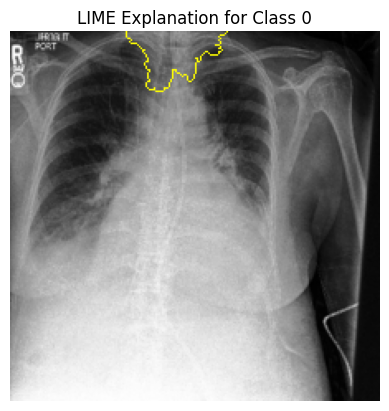

In [248]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import mark_boundaries
import torchvision.transforms as transforms
from PIL import Image

# Ensure your model is in evaluation mode and on the proper device.
model_densenet121.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_densenet121.to(device)


def denormalize2numpy(img_tensor):
    # Unnormalize the image: original = normalized * std + mean
    # Since mean=0.5 and std=0.5 for grayscale images:
    unnormalized = img_tensor * 0.5 + 0.5  #torch.Size([3, 224, 224])
    # Convert tensor from (C, H, W) to (H, W, C)
    img_np = unnormalized.permute(1, 2, 0).cpu().numpy() #(224, 224, 3)
    return img_np

# Assuming you have obtained an image from your testloader:
# For example, grabbing the first image from a batch:
dataiter = iter(test_loader)
images, labels = next(dataiter)
img = images[5]  # select the first image from the batch
img_np = denormalize2numpy(img)

# Prediction function for LIME:
def predict_fn(images):
    """
    images: list/array of images in NumPy format (H x W x C), with pixel values in [0, 1].
    Returns: a NumPy array of shape (n_samples, 2) with class probabilities.
    """
    # Convert each LIME image (numpy array) to a PIL image, then to a tensor.
    tensor_images = [
        transforms.ToTensor()(Image.fromarray((img * 255).astype(np.uint8)))
        for img in images
    ]
    # Stack into a single batch tensor of shape (N, C, H, W)
    batch = torch.stack(tensor_images).to(device)
    
    with torch.no_grad():
        outputs = model_densenet121(batch)  # outputs shape: (batch, 1)
        # Apply sigmoid to get probability for class 1.
        probs_class1 = torch.sigmoid(outputs)
        # Create two-class probabilities: class0 = 1 - p, class1 = p.
        probs = torch.cat([1 - probs_class1, probs_class1], dim=1)
        print(probs)
    
    return probs.cpu().numpy()

# Create LIME image explainer.
explainer = LimeImageExplainer()

# Explain the prediction for the chosen image.
# For binary classification, we can set top_labels=2.
explanation = explainer.explain_instance(
    img_np,   
    predict_fn,
    top_labels=2,              # With binary classification, there are two labels.
    hide_color=0,
    num_samples=1000           # Number of perturbed samples
)

# Choose the label you wish to explain. For example, to explain class 1 (positive class):
label_to_explain = 0  # or use explanation.top_labels[0] if that suits your needs

# Get the explanation mask.
temp, mask = explanation.get_image_and_mask(
    label=label_to_explain,
    positive_only=True,
    num_features=1,
    hide_rest=False
)

# Visualize the explanation.
plt.imshow(mark_boundaries(temp, mask))
plt.title(f"LIME Explanation for Class {label_to_explain}")
plt.axis("off")
plt.show()


##### Gradcam based on paper: https://arxiv.org/abs/1610.02391
##### Library: https://github.com/jacobgil/pytorch-grad-cam

In [260]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

def apply_gradcam(model, image_path, transform, target_layer=None):
    """
    Apply Grad-CAM to the specified image using the provided DenseNet121 model.
    
    Args:
        model: The trained DenseNet121 model.
        image_path: Path to the image for visualization.
        transform: Image transformation pipeline.
        target_layer: The target convolutional layer for Grad-CAM. If None, uses a default layer.
        target_category: (Optional) Target class index for which to compute Grad-CAM.
    
    Returns:
        Tuple of (resized original image, Grad-CAM heatmap, overlayed image).
    """
    # Ensure the model is in evaluation mode and gradients are enabled
    model.eval()
    for param in model.parameters():
        param.requires_grad = True

    # Load the image and get the original image (without resizing)
    img = Image.open(image_path).convert('RGB')
    original_img = np.array(img, dtype=np.float32) / 255.0  # Original resolution

    # Preprocess the image (this resizes the image to the size expected by the model)
    input_tensor = transform(img).unsqueeze(0)  # Add batch dimension

    # If no target layer specified, choose the last conv layer in denseblock4.
    if target_layer is None:
        try:
            # Using the last convolution from denselayer16 in denseblock4
            target_layer = [model.features.denseblock4.denselayer16.conv2]
        except AttributeError:
            # Fallback: use an alternative convolutional layer
            target_layer = [model.features[-2]]

    # Create GradCAM object
    cam = GradCAM(model=model, target_layers=target_layer)

    targets = [ClassifierOutputTarget(0)]

    
    print(targets)

    # Generate Grad-CAM heatmap (this triggers the backward pass)
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0]
    
    # Normalize the Grad-CAM output to the range [0, 1]
    # grayscale_cam = (grayscale_cam - grayscale_cam.min()) / (grayscale_cam.max() - grayscale_cam.min() + 1e-8)
    
    # Resize the original image to match the Grad-CAM output dimensions if needed
    if original_img.shape[:2] != grayscale_cam.shape: #OTHERWISE  <<ValueError: operands could not be broadcast together with shapes (224,224,3) (320,357,3) THIS SH happens >> 
        original_img_resized = cv2.resize(original_img, (grayscale_cam.shape[1], grayscale_cam.shape[0])) 
    else:
        original_img_resized = original_img

    # Overlay the heatmap on the resized original image
    overlay = show_cam_on_image(original_img_resized, grayscale_cam, use_rgb=True)

    return original_img_resized, overlay




In [261]:
densenet121

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
model

actual label 1


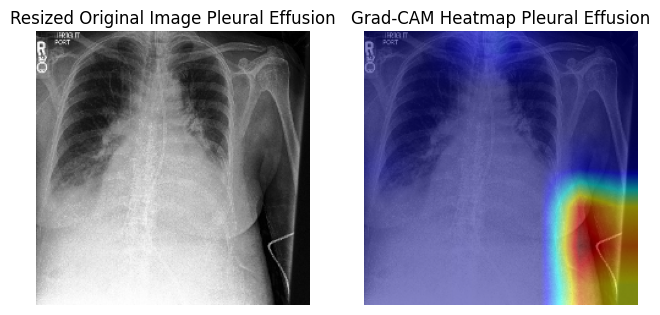

actual label 1


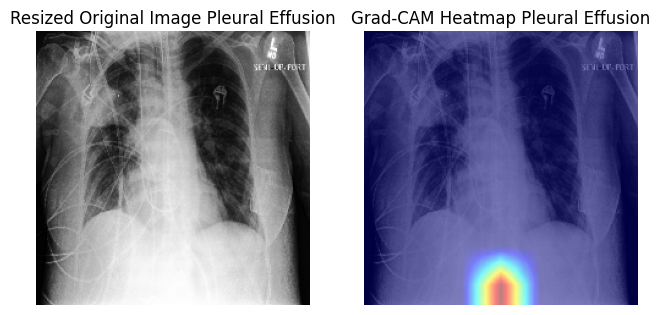

actual label 1


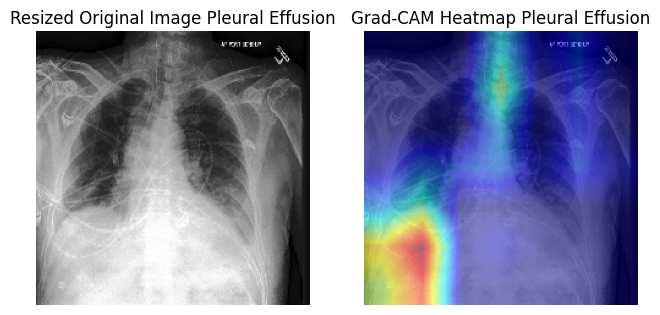

actual label 1


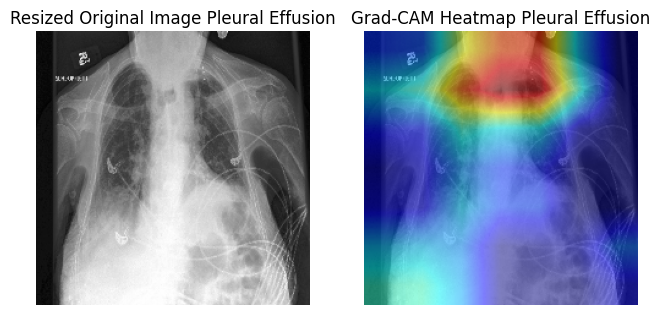

actual label 1


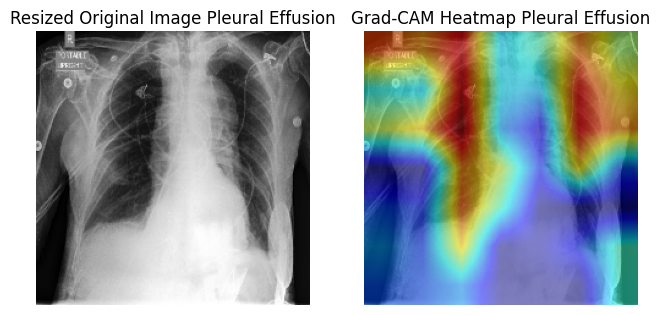

actual label 1


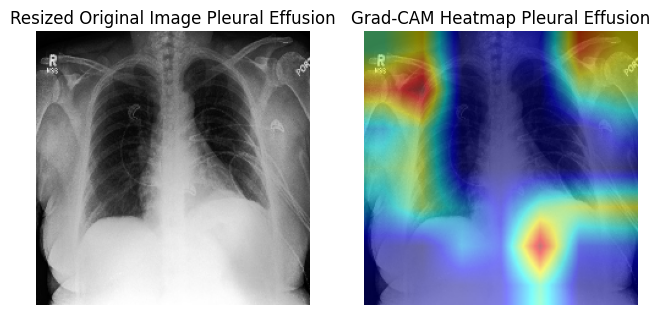

actual label 1


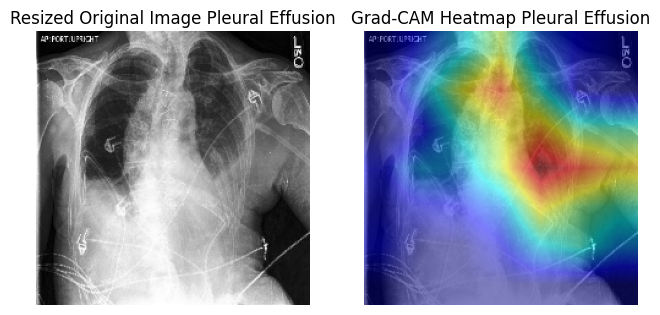

actual label 1


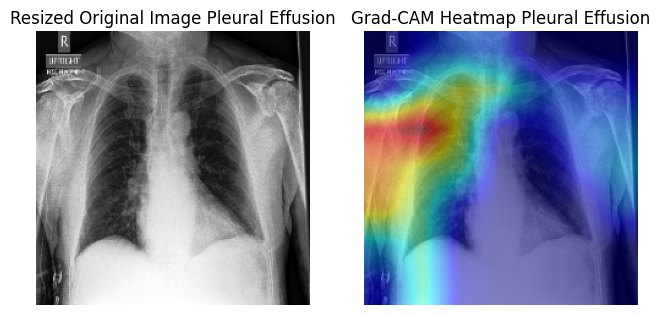

actual label 1


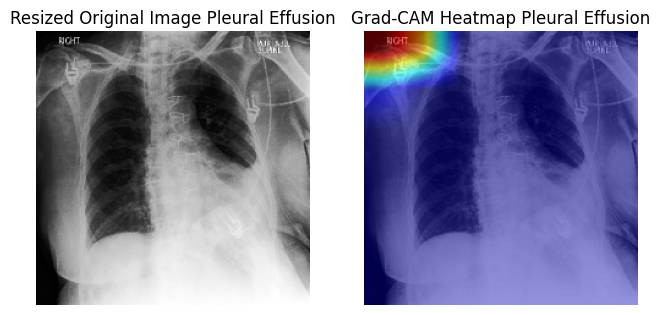

actual label 1


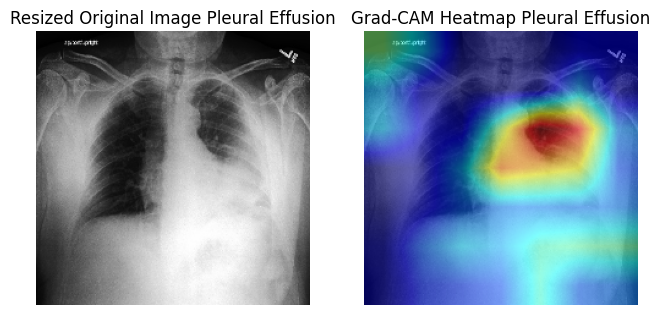

actual label 1


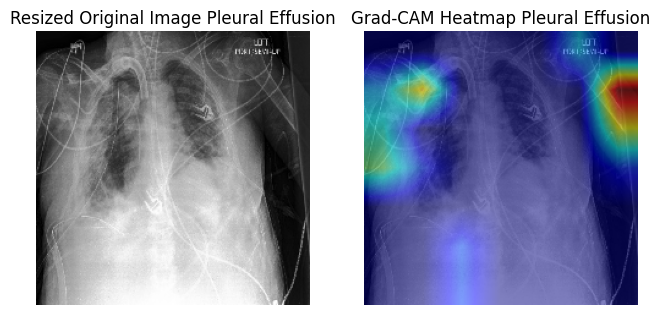

actual label 1


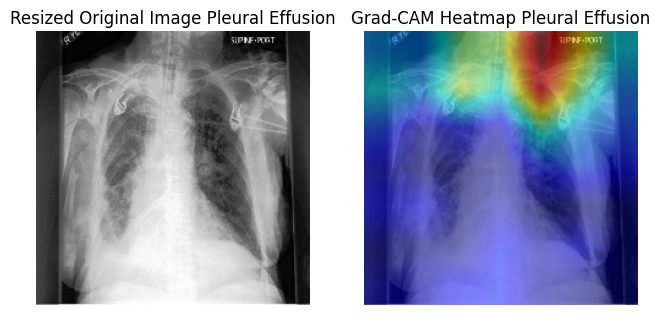

actual label 1


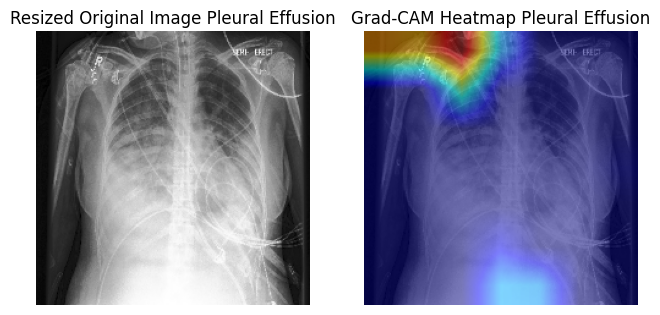

actual label 1


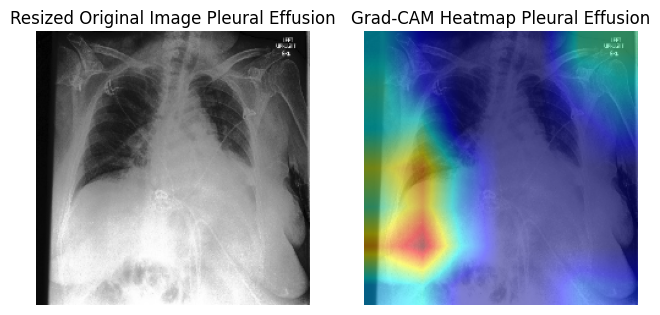

actual label 1


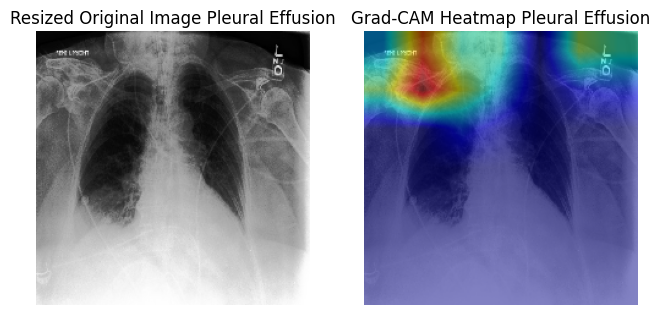

In [258]:
test_df_filtered = test_df[test_df['Pleural Effusion'] == 1]

for i in range(0, 60, 4):
    image_path = test_df_filtered.iloc[i]['path']
    actual_label = test_df_filtered.iloc[i]["Pleural Effusion"]  

    print(f"actual label {actual_label}")
    # Only process images with effusion (label==1)
    if actual_label == 1:
        original_img, overlay = apply_gradcam(
            model=densenet121, 
            image_path=image_path, 
            transform=transform,
        )
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(original_img)
        plt.title("Resized Original Image Pleural Effusion")
        plt.axis("off")
        
        plt.subplot(1, 3, 2)
        plt.imshow(overlay)
        plt.title("Grad-CAM Heatmap Pleural Effusion")
        plt.axis("off")
        
        
        plt.show()
